### Notebook to explore UNet for supervised segmentation
For personal exploration only; supervised methods are unlikely to be of scientic interest

In [5]:
import numpy as np
import os, sys
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
sys.path.insert(0, '../utils')
import data_utils, run_utils

/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### UNET

UNet: 13
Total validation accuracy: 88.82%
	84.28419341771152% of intergranule pixels correctly identified
	50.323578356390044% of dim middle pixels correctly identified
	93.32656484439849% of granule pixels correctly identified
	78.5753727222529% of bright point pixels correctly identified


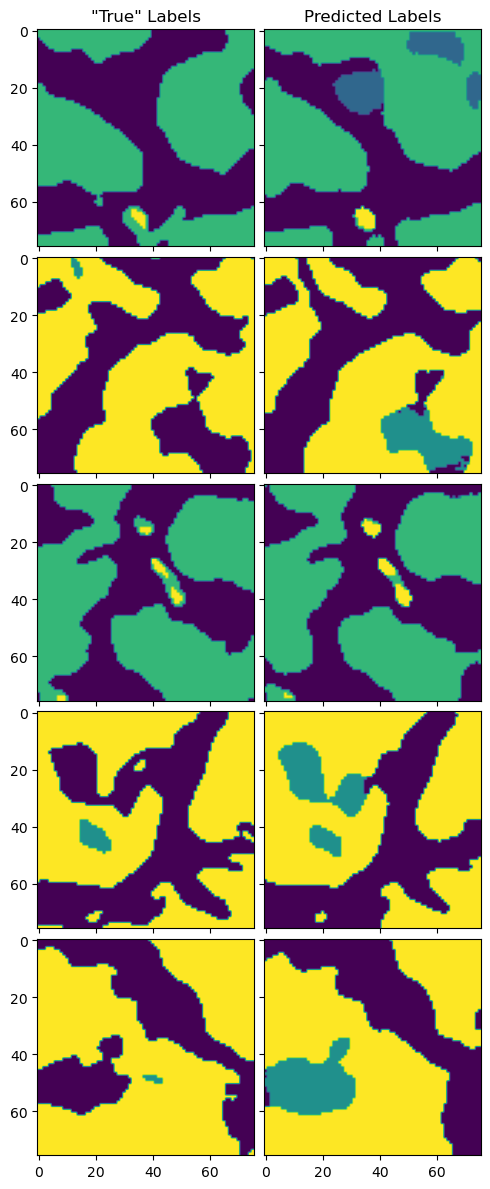

In [23]:
'''
Explore results of one model
'''

UNet_num = '13'
n_classes = 4

# Compute total validation accuracy
output_dir = f'../../UNet_runs/exp{UNet_num}/UNet{UNet_num}_outputs'
pct_correct, pct_ig_correct, pct_dm_correct, pct_gr_correct, pct_bp_correct = run_utils.compute_validation_results(output_dir, n_classes)
print(f'UNet: {UNet_num}')
print(f"Total validation accuracy: {pct_correct:.2f}%") 
print(f'\t{pct_ig_correct}% of intergranule pixels correctly identified')
print(f'\t{pct_dm_correct}% of dim middle pixels correctly identified')
print(f'\t{pct_gr_correct}% of granule pixels correctly identified')
print(f'\t{pct_bp_correct}% of bright point pixels correctly identified')

# Display a random sample of images
fig, axs = plt.subplots(5, 2, figsize=(5, 12), sharex=True, sharey=True)
axs[0,0].set_title('"True" Labels')
axs[0,1].set_title('Predicted Labels')
for i in range(5):
    idx = np.random.randint(0, 396)
    im = np.load(f'{output_dir}/x_{idx}.npy')[0] # first index to get image
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,0].imshow(true) # vmin=0, vmax=1.5
    axs[i,1].imshow(preds) # vmin=0, vmax=1.5
fig.tight_layout()
plt.subplots_adjust(hspace=0.05)

#### Traditional ML

As expected, models are successfull at learning the thresholding perfectly

In [24]:
'''
Compare various models
'''

# Compile data (concate series 183653) 
data = []
labels = []
for file in os.listdir('../Data/DKIST_gband_Feb06_series_183653/'):
        if file.startswith('SEG_VBI'):
            dat = fits.open('../Data/DKIST_gband_series_183653/'+file)
            img = dat[1].data.byteswap().newbyteorder()
            seg = dat[0].data.byteswap().newbyteorder()[0]
            data = np.concatenate((data, img), axis=1)
            labels = np.concatenate((labels, seg), axis=1)

# Prepare half for training and testing (split along 'short' axis to encompass all)
tt_data = data[0:int(np.shape(data)[0]/2), :]
tt_labels = labels[0:int(np.shape(data)[0]/2), :]
X_tt, Y_tt = data_utils.pre_proccess(tt_data, tt_labels)
X_train, X_test, Y_train, Y_test = train_test_split(X_tt, Y_tt, test_size=0.4, random_state=20)

# Prepare other half for test
tt_data = data[int(np.shape(data)[0]/2):-1, :]
tt_labels = labels[int(np.shape(data)[0]/2):-1, :]
X_test, Y_test = data_utils.pre_proccess(tt_data, tt_labels)

# RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, Y_train)
pred = model.predict(X_test)
print('RF test accuracy:', metrics.accuracy_score(Y_test, pred))

# KNeighborsClassifier 
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, Y_train)
pred =  model.predict(X_test)
print('KNN test accuracy:', metrics.accuracy_score(Y_test, pred))


FileNotFoundError: [Errno 2] No such file or directory: '../Data/DKIST_example.fits'